In [39]:
# https://climcal4.giub.unibe.ch:8000/user/hugo/?token=a71c03fa9afc41be95bbad3a0ba9d739
import os
import sys
import numpy as np
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feat
import xrft
import pickle as pkl
from scipy import constants as co
import matplotlib.animation as animation
import matplotlib.pyplot as plt
# from sklearn.neighbors import KernelDensity

import IPython.display as disp
from metpy import calc as mcalc
from metpy import interpolate as minterpolate
from metpy.units import units
import pandas as pd
import time
from ipywidgets import IntProgress, HTML
import shutil
from cdo import Cdo
from nco import Nco
# from definitions import *

plt.rcParams['animation.ffmpeg_path'] = '/home/hugo/mambaforge-pypy3/envs/env/bin/ffmpeg'
# cdo = Cdo()
# nco = Nco()
# %matplotlib inline

In [3]:
DATADIR = "/scratch2/hugo/ERA5"
CLIMSTOR = "/mnt/climstor/ecmwf/era5/raw"

def filenamescm(y, m, d):  # Naming conventions of the files on climstor (why are they so different?)
    return [f"{CLIMSTOR}/ML/data/{str(y)}/P{str(y)}{str(m).zfill(2)}{str(d).zfill(2)}_{str(h).zfill(2)}" for h in range(0, 24, 6)]
def filenamecp(y, m, d):
    return [f"{CLIMSTOR}/PL/data/an_pl_ERA5_{str(y)}-{str(m).zfill(2)}-{str(d).zfill(2)}.nc"]  # returns iterable to have same call signature as filenamescl(y, m, d)
def filenamegeneric(y, m, folder):
    return [f"{DATADIR}/{folder}/{y}{str(m).zfill(2)}.nc"]

def _fn(date, which):
    if which == "ML":
        return filenamescm(date.year, date.month, date.day)
    elif which == "PL":
        return filenamecp(date.year, date.month, date.day)
    else:
        return filenamegeneric(date.year, date.month, which)
    
def fn(date, which):  # instead takes pandas.timestamp (or iterable of _) as input
    if isinstance(date, (list, np.ndarray, pd.DatetimeIndex)):
        filenames = []
        for d in date:
            filenames.extend(_fn(d, which))
        return filenames
    elif isinstance(date, pd.Timestamp):
        return _fn(date, which)
    else:
        raise RuntimeError(f"Invalid type : {type(date)}")

RADIUS = 6.371e6  # m
OMEGA = 7.2921e-5  # rad.s-1
KAPPA = 0.2854
R_SPECIFIC_AIR = 287.0500676

def degcos(x):
    return np.cos(x / 180 * np.pi)
def degsin(x):
    return np.sin(x / 180 * np.pi)

DATERANGEPL = pd.date_range("19590101", "20021231")
YEARSPL = np.unique(DATERANGEPL.year)
DATERANGEML = pd.date_range("19770101", "20211231")
WINDBINS = np.arange(0, 25, 2)
LATBINS = np.arange(15, 75, 2.5)
LONBINS = np.arange(-90, 30, 3)
DEPBINS = np.arange(-25, 26, 1.5)

COLORS = [     # https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c
    "#ef476f", # pinky red
    "#ffd166", # yellow
    "#06d6a0", # cyany green
    "#118ab2", # light blue
    "#073b4c", # dark blue
]

### Zoo computation:

In [16]:
### Create histogram
def histogram(timeseries, season=None, bins=LATBINS, fig=None, ax=None, **kwargs):
    if season is not None:
        timeseries = timeseries.isel(time=timeseries.time.dt.season==season)
    if ax is None:
        fig, ax = plt.subplots()
    hist = xr.plot.hist(timeseries, ax=ax, bins=bins, edgecolor="black", **kwargs)
    return fig, ax, hist

In [17]:
### Lat and Int
def compute_JLI(da_Lat):
    LatI = da_Lat.argmax(dim="lat", skipna=True)
    Lat = xr.DataArray(da_Lat.lat[LatI.values.flatten()].values, coords={"time": da_Lat.time}).rename("Lat")
    Lat.attrs["units"] = "degree_north"
    Int = da_Lat.isel(lat=LatI).reset_coords("lat", drop=True).rename("Int")
    Int.attrs["units"] = "m/s"
    Latg = Lat.groupby("time.dayofyear")
    Latmean = Latg.mean(dim="time")
    ft = xrft.fft(Latmean, dim="dayofyear")
    ft[:int(len(ft) / 2) - 3] = 0
    ft[int(len(ft) / 2) + 3:] = 0
    Latsmooth = xrft.ifft(ft, dim="freq_dayofyear", true_phase=True, true_amplitude=True).real.assign_coords(dayofyear=Latmean.dayofyear)
    return Lat, Int, Latmean, Latsmooth

In [18]:
### Shar, Latn, Lats, 
def compute_shar(da_Lat, Int, Lat):
    Shar = (Int - da_Lat.mean(dim="lat")).rename("Shar")
    Shar.attrs["units"] = Int.attrs["units"]
    this = da_Lat - Shar / 2
    ouais = np.where(this.values[:, 1:] * this.values[:, :-1] < 0)
    hist = np.histogram(ouais[0], bins=np.arange(len(da_Lat.time) + 1))[0]
    cumsumhist = np.append([0], np.cumsum(hist)[:-1])
    Lats = xr.DataArray(da_Lat.lat.values[ouais[1][cumsumhist]], coords={"time": da_Lat.time}, name="Lats")
    Latn = xr.DataArray(da_Lat.lat.values[ouais[1][cumsumhist + hist - 1]], coords={"time": da_Lat.time}, name="Latn")
    Latn[Latn < Lat] = da_Lat.lat[-1]
    Lats[Lats > Lat] = da_Lat.lat[0]
    Latn.attrs["units"] = "degree_north"
    Lats.attrs["units"] = "degree_north"
    return Shar, Lats, Latn

In [19]:
### Tilt
def compute_Tilt(da, Lat):
    trackedLats = da.isel(lat=0).copy(data=np.zeros(da.shape[:2])).reset_coords("lat", drop=True).rename("Tracked Latitudes")
    trackedLats.attrs["units"] = "degree_north"
    lats = da.lat.values
    twodelta = lats[2] - lats[0]
    midpoint = int(len(da.lon) / 2)
    trackedLats[:, midpoint] = Lat
    iterator = zip(reversed(range(midpoint)), range(midpoint + 1, len(lats)))
    for lonw, lone in iterator:
        for k, thislon in enumerate((lonw, lone)):
            otherlon = thislon - (2 * k - 1) # previous step in the iterator for either east (k=1, otherlon=thislon-1) or west (k=0, otherlon=thislon+1)
            mask = np.abs(trackedLats[:, otherlon].values[:, None] - lats[None, :]) > twodelta 
            # mask = where not to look for a maximum. The next step (forward for east or backward for west) needs to be within twodelta of the previous (otherlon)
            here = np.ma.argmax(np.ma.array(da.isel(lon=thislon).values, mask=mask), axis=1)
            trackedLats[:, thislon] = lats[here]
    Tilt = trackedLats.polyfit(dim="lon", deg=1).sel(degree=1)["polyfit_coefficients"].reset_coords("degree", drop=True).rename("Tilt")
    Tilt.attrs["units"] = "degree_north/degree_east"
    return trackedLats, Tilt

In [20]:
### Lon
def compute_Lon(da, trackedLats):
    Intlambda = da.sel(lat=trackedLats).reset_coords("lat", drop=True)
    Intlambdasq = Intlambda * Intlambda
    lons = xr.DataArray(da.lon.values[None, :] * np.ones(len(da.time))[:, None], coords={"time": da.time, "lon": da.lon})
    Lon = (lons * Intlambdasq).sum(dim="lon") / Intlambdasq.sum(dim="lon")
    Lon.attrs["units"] = "degree_east"
    return Intlambda, Lon.rename("Lon")

In [21]:
### Lonw, Lone
def compute_Lonew(da, Intlambda, Lon):
    Intlambda = Intlambda.values
    Mean = np.mean(Intlambda, axis=1)
    lon = da.lon.values
    iLon = np.argmax(lon[None, :] - Lon.values[:, None] > 0, axis=1)
    basearray = Intlambda - Mean[:, None] < 0
    iLonw = np.ma.argmin(np.ma.array(basearray, mask=lon[None, :] > Lon.values[:, None]), axis=1) - 1
    iLone = np.ma.argmax(np.ma.array(basearray, mask=lon[None, :] <= Lon.values[:, None]), axis=1) - 1
    Lonw = xr.DataArray(lon[iLonw], coords={"time": da.time}, name="Lonw")
    Lone = xr.DataArray(lon[iLone], coords={"time": da.time}, name="Lone")
    Lonw.attrs["units"] = "degree_east"
    Lone.attrs["units"] = "degree_east"
    return Lonw, Lone

In [22]:
### Dep
def compute_Dep(da, trackedLats):
    phistarl = xr.DataArray(da.lat.values[da.argmax(dim="lat").values], coords={"time": da.time.values, "lon": da.lon.values})
    Dep = np.sqrt((phistarl - trackedLats) ** 2).sum(dim="lon").rename("Dep")
    Dep.attrs["units"] = "degree_north"
    return Dep

# JLI computations on scratch/ERA5/Wind/ files, following Woollings et al. 2010

In [ ]:
# Step 1 : extraction of daily mean zonal wind, averaged over 4 p levels
files = np.asarray([filenamegeneric(y, m, "Woollings_daily") for y in YEARSPL for m in range(1, 13)]).flatten()
da = xr.open_mfdataset(files, concat_dim="time", combine='nested', engine="netcdf4")["u"].isel(lon=0)

In [ ]:
# Alt : file from era40
da = xr.open_dataset("/scratch2/hugo/ERA40/Woollings.nc")["u"].isel(lon=0).interp(lat=np.arange(15, 76, 2.5))

In [ ]:
# Lanczos filtering
def low_pass_weights(window, cutoff):  # shamefully stolen from https://github.com/liv0505/Lanczos-Filter
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

window = 61
weights = xr.DataArray(low_pass_weights(window, 1 / 10), dims=["window"])
da2 = da.rolling(time=len(weights), center=True).construct("window").dot(weights).isel(time=range(int(window / 2), len(da.time) - int(window / 2)))

In [ ]:
# Alternative : xrft filtering. Gives very similar results
da_fft = xrft.fft(da.chunk((len(da.time), 1, 1)), dim="time")
da_fft[np.abs(da_fft.freq_time) > 1 / 10 / 24 / 3600] = 0
da3 = xrft.ifft(da_fft, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=da.time)

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Lat, Int, Latmean, Latsmooth = compute_JLI(da3.load(), True)
# timeseries = (Lat.groupby("time.dayofyear") - Latsmooth)
# timeseries = timeseries.isel(time=(timeseries.time.dt.season=="DJF"))
# bins = np.arange(-29.5, 31, 2)
# hist = xr.plot.hist(timeseries, ax=ax, bins=bins, alpha=0.5, color="tab:blue", label="xrft")
Lat, Int, Latmean, Latsmooth = compute_JLI(da2.load())
winter = np.logical_or(Latsmooth.dayofyear <= 30, Latsmooth.dayofyear >= 306)
# timeseries = (Lat.groupby("time.dayofyear") - Latsmooth)
# timeseries = timeseries.isel(time=(timeseries.time.dt.season=="DJF"))
timeseries = Lat
timeseries = timeseries.isel(time=(timeseries.time.dt.season=="DJF"))

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


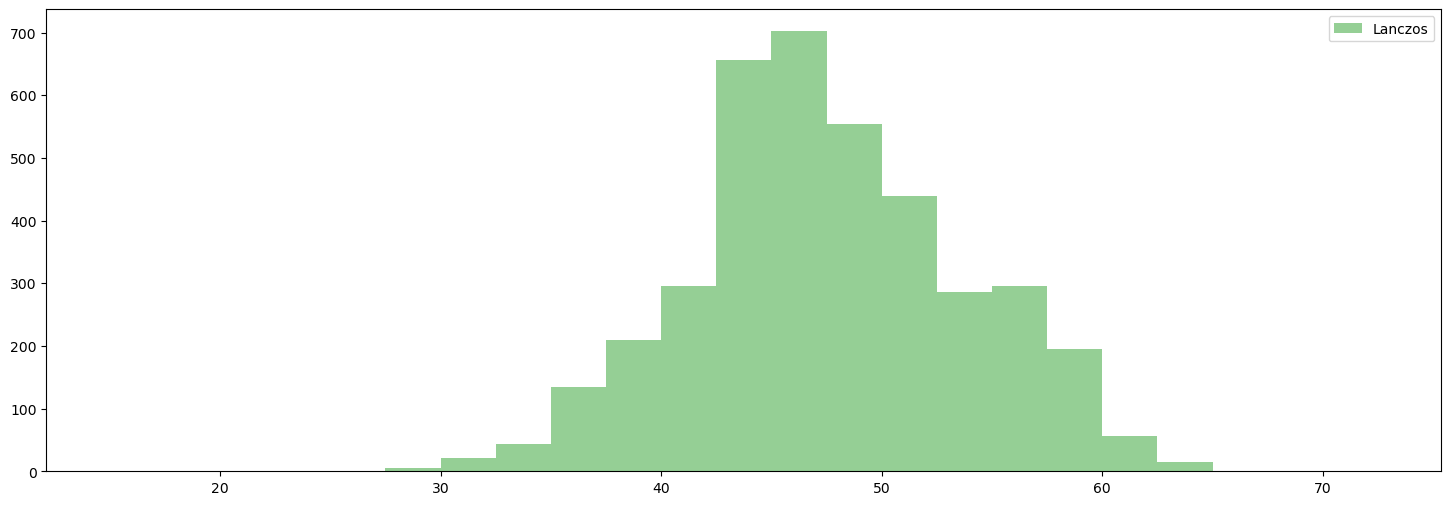

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
bins = np.arange(15, 75, 2.5)
hist = xr.plot.hist(timeseries, ax=ax, bins=bins, alpha=0.5, color="tab:green", label="Lanczos")
ax.legend()

In [ ]:
Lat.groupby("time.dayofyear").mean()

<xarray.DataArray (dayofyear: 366)>
array([45.76744186, 45.41860465, 45.8255814 , 46.        , 46.75581395,
       47.10465116, 47.04651163, 46.81395349, 46.81395349, 46.81395349,
       46.63953488, 46.29069767, 46.93023256, 47.3372093 , 47.22093023,
       47.27906977, 47.27906977, 47.51162791, 47.22093023, 47.22093023,
       46.46511628, 46.93023256, 47.04651163, 47.04651163, 47.45348837,
       47.45348837, 47.45348837, 47.74418605, 47.3372093 , 47.56976744,
       47.25      , 47.59090909, 48.04545455, 47.70454545, 48.27272727,
       48.10227273, 46.90909091, 47.02272727, 47.36363636, 47.64772727,
       47.30681818, 47.07954545, 47.02272727, 47.25      , 47.64772727,
       47.64772727, 48.15909091, 48.10227273, 47.76136364, 47.70454545,
       47.47727273, 47.93181818, 48.04545455, 48.38636364, 47.93181818,
       47.47727273, 48.04545455, 48.27272727, 48.44318182, 49.06818182,
       49.18181818, 49.29545455, 48.5       , 48.04545455, 48.44318182,
       48.89772727, 49.46590909, 49.75      , 48.10227273, 49.57954545,
       49.86363636, 49.97727273, 49.57954545, 49.35227273, 50.14772727,
       50.20454545, 49.18181818, 48.78409091, 48.95454545, 49.125     ,
       49.57954545, 49.86363636, 49.86363636, 49.35227273, 50.375     ,
       50.03409091, 49.97727273, 49.52272727, 49.52272727, 48.04545455,
       47.81818182, 47.47727273, 46.96590909, 47.81818182, 48.67045455,
       50.20454545, 49.57954545, 49.63636364, 50.31818182, 49.86363636,
...
       49.69318182, 49.57954545, 49.80681818, 50.09090909, 50.09090909,
       50.375     , 50.20454545, 50.77272727, 50.94318182, 51.05681818,
       51.39772727, 51.625     , 51.45454545, 49.97727273, 50.14772727,
       50.31818182, 48.78409091, 48.89772727, 48.95454545, 49.125     ,
       48.44318182, 49.57954545, 49.80681818, 50.48863636, 50.09090909,
       50.48863636, 50.43181818, 50.71590909, 50.20454545, 50.14772727,
       49.75      , 49.63636364, 49.52272727, 50.14772727, 49.23863636,
       49.69318182, 50.31818182, 50.71590909, 50.31818182, 50.03409091,
       49.75      , 49.06818182, 49.18181818, 49.46590909, 49.35227273,
       49.57954545, 49.18181818, 48.89772727, 48.55681818, 48.84090909,
       50.03409091, 49.92045455, 49.18181818, 48.61363636, 48.61363636,
       48.27272727, 48.5       , 48.44318182, 49.18181818, 49.40909091,
       49.18181818, 48.89772727, 48.5       , 48.10227273, 47.875     ,
       48.15116279, 48.20930233, 47.74418605, 47.97674419, 48.6744186 ,
       48.3255814 , 47.68604651, 47.86046512, 48.15116279, 47.62790698,
       47.91860465, 47.80232558, 47.56976744, 48.3255814 , 47.80232558,
       46.1744186 , 45.88372093, 46.46511628, 46.81395349, 46.75581395,
       46.87209302, 46.93023256, 47.27906977, 47.1627907 , 47.04651163,
       46.46511628, 47.22093023, 46.58139535, 46.63953488, 46.81395349,
       44.86363636])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

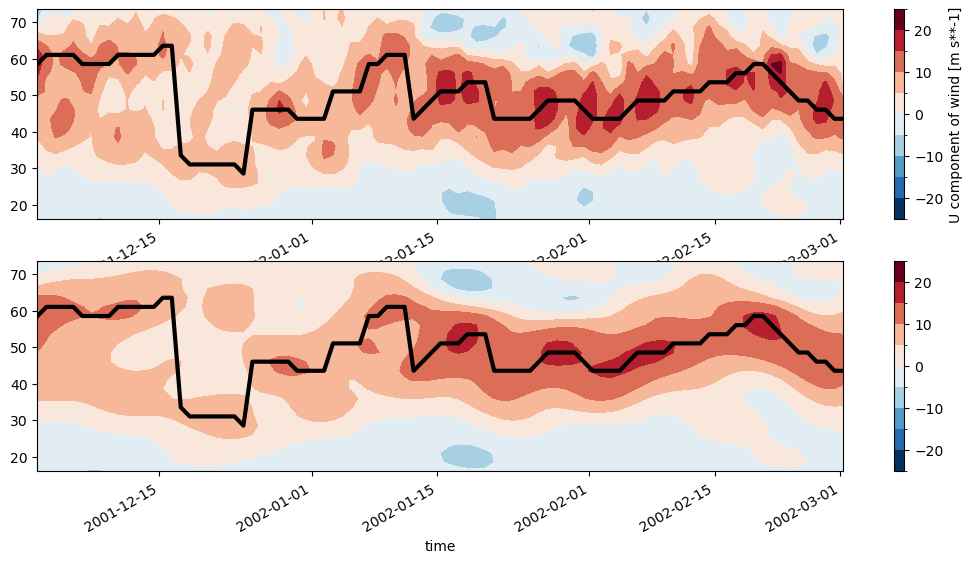

In [ ]:
# Trying to reproduce figure 3 of Woollings et al. 2010
fig, axes = plt.subplots(2, 1, figsize=(13, 6))
winter0102 = pd.date_range("2001-12-01 09:00:00", "2002-03-01 09:00:00", freq="1D")
levels = np.arange(-25, 26, 5)
da.sel(time=winter0102).transpose().plot.contourf(ax=axes[0], levels=levels)
da2.sel(time=winter0102).transpose().plot.contourf(ax=axes[1], levels=levels)
Lat.sel(time=winter0102).plot(ax=axes[0], color="black", lw=3)
Lat.sel(time=winter0102).plot(ax=axes[1], color="black", lw=3)

In [ ]:
dafull = xr.open_dataset("/scratch2/hugo/ERA40/UandVregridded2.nc").isel(time=range(int(window / 2), len(da.time) - int(window / 2)), lat=np.arange(4, 75), lon=np.arange(60, 200))
dafull = dafull.isel(time=(dafull.time.dt.season=="DJF"))

In [ ]:
dafull["speed"] = np.sqrt(dafull["u"] ** 2 + dafull["v"] ** 2)

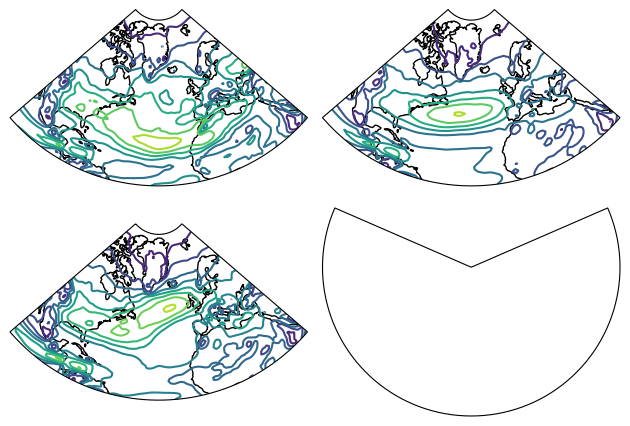

In [ ]:
lon, lat = dafull.lon.values, dafull.lat.values
digitized = np.digitize(timeseries, bins=bins)
transform = ccrs.LambertConformal(
    central_longitude=np.mean(lon),
)
projection = transform
fig, axes = plt.subplots(
    2, 2, tight_layout=True, 
    subplot_kw={"projection": projection}
)
to_plot.plot(transform=transform)
ax.add_feature(coastline)
ax.add_feature(borders)
ax.set_xmargin(0)
ax.set_ymargin(0)

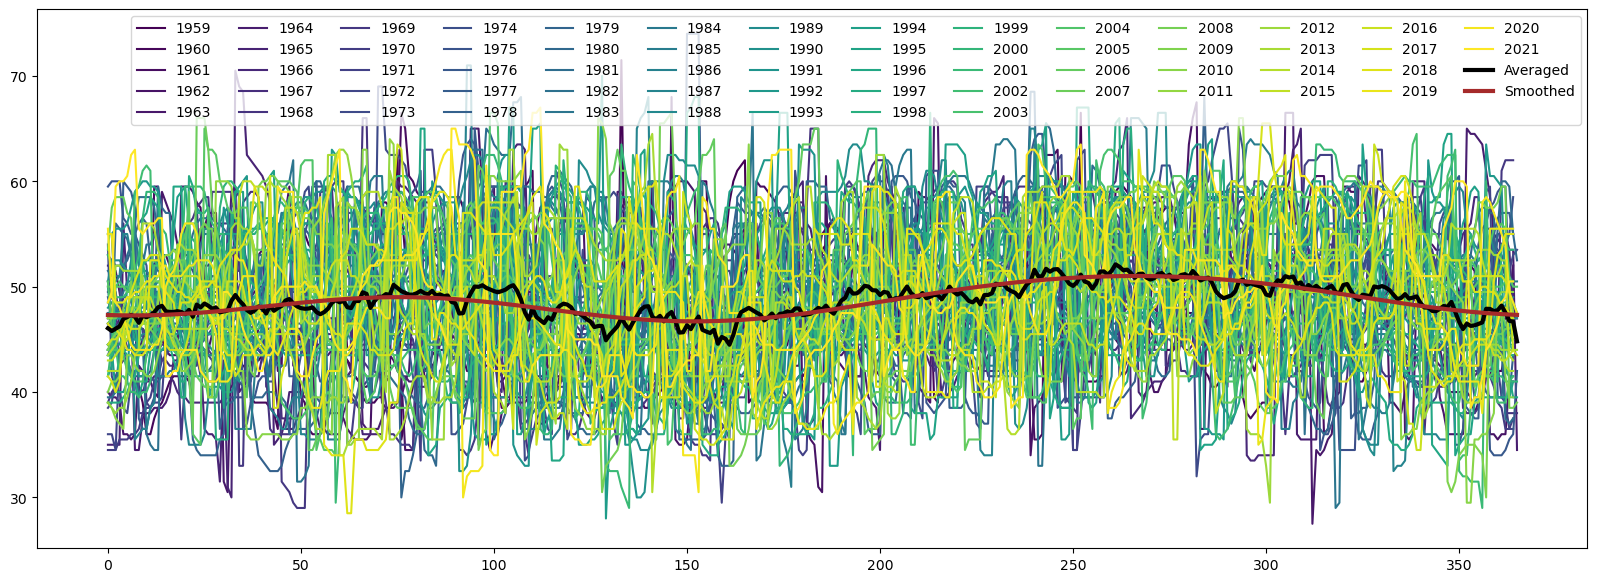

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
groups = Lat.groupby("time.year")
ng = len(groups)
colors = plt.colormaps["viridis"](np.linspace(0, 1, ng))
for i, g in enumerate(groups):
    j, g = g
#     ax.plot(g.isel(time=(g.time.dt.season=="DJF")), label=j, color=colors[i])
    ax.plot(g, label=j, color=colors[i])
winter = np.logical_or(Latsmooth.dayofyear <= 366, Latsmooth.dayofyear >= 355)
ax.plot(Latmean.isel(dayofyear=winter), lw=3, color="black", label="Averaged")
ax.plot(Latsmooth.isel(dayofyear=winter), lw=3, color="brown", label="Smoothed")
ax.legend(ncol=14)
plt.show()

# Barriopedro

### Package NCEP Data

In [ ]:
# on cal4
datadir = "/scratch2/hugo/NCEP/data"
da = xr.open_dataset(f"{datadir}/Barriopedro1.nc")["uwnd"]
da2 = da.rolling(lon=24, center=True).mean().isel(lon=np.arange(12, 37))
da_fft = xrft.fft(da2, dim="time")
da_fft[np.abs(da_fft.freq_time) > 1 / 10 / 24 / 3600] = 0
da3 = xrft.ifft(da_fft, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=da.time).rename("u")
da2.attrs["unit"] = "m/s"
da3.attrs["unit"] = "m/s"
da3.to_netcdf(f"{datadir}/Barriopedro3.nc")

### Compute with NCEP

In [94]:
datadir = "/scratch2/hugo/NCEP/data"
da3 = xr.open_dataarray(f"{datadir}/Barriopedro3.nc")
da_Lat = da3.sel(lon=-30.).reset_coords("lon", drop=True)
Lat, Int, Latmean, Latsmooth = compute_JLI(da_Lat)
Shar, Lats, Latn = compute_shar(da_Lat, Int, Lat)
trackedLats, Tilt = compute_Tilt(da3, Lat)
Intlambda, Lon = compute_Lon(da3, trackedLats)
Lonw, Lone = compute_Lonew(da3, Intlambda, Lon)
Dep = compute_Dep(da3, trackedLats)
Zoo = xr.Dataset({
    "Lat": Lat, 
    "Int" : Int, 
    "Shar": Shar, 
    "Lats": Lats, 
    "Latn" : Latn, 
    "Tilt" : Tilt, 
    "Lon" : Lon, 
    "Lonw" : Lonw, 
    "Lone" : Lone, 
    "Dep" : Dep,
})
Zoo.to_netcdf("/scratch2/hugo/BarriopedroZooNCEP.nc")

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


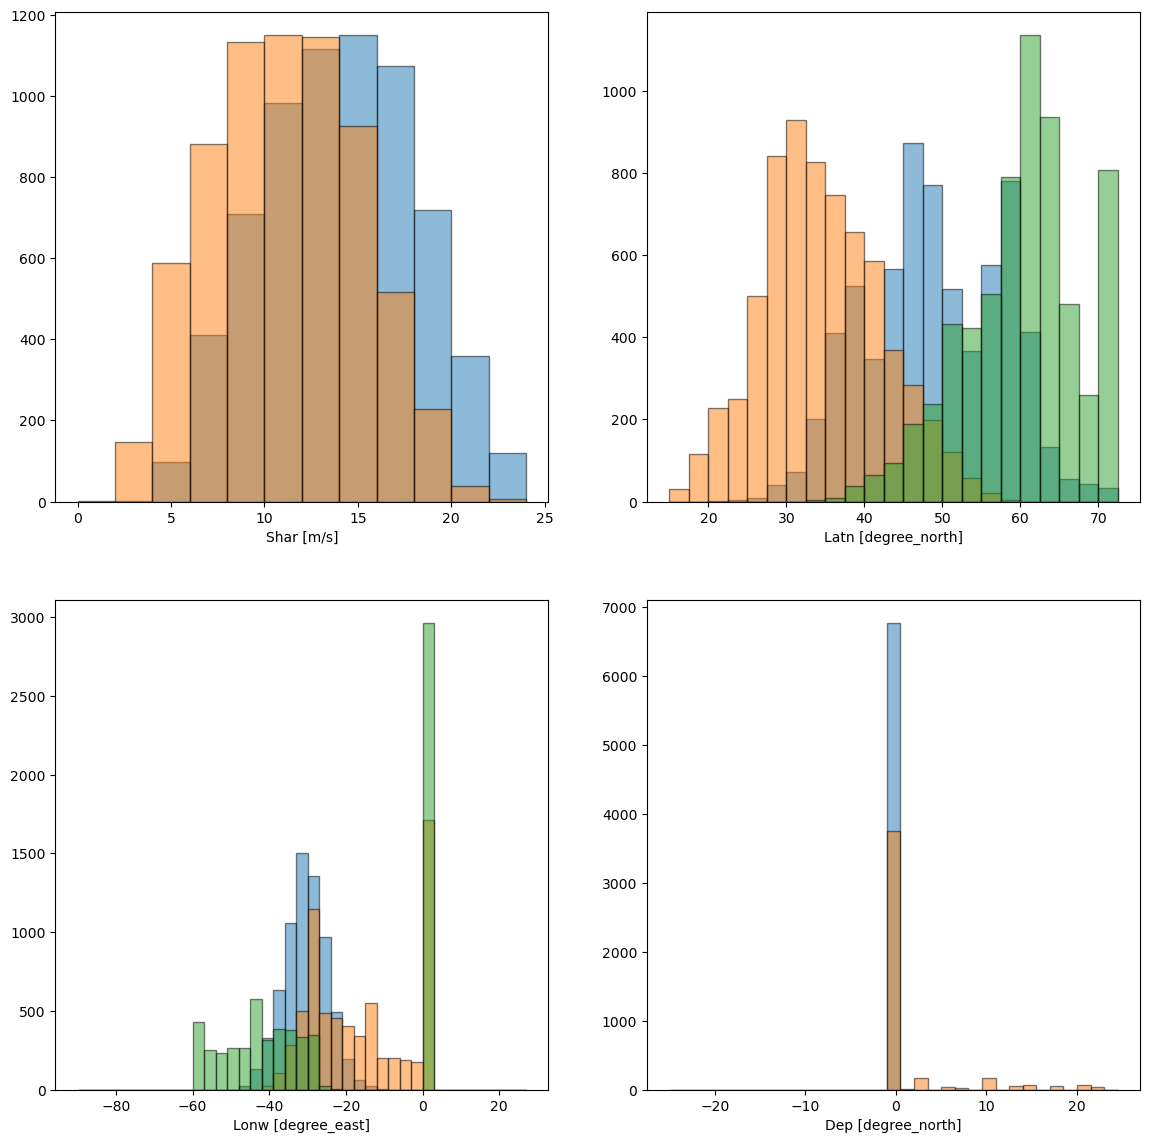

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
mapping = [["Int", "Shar"], ["Lat", "Lats", "Latn"], ["Lon", "Lone", "Lonw"], ["Tilt", "Dep"]]
bins = [WINDBINS, LATBINS, LONBINS, DEPBINS]
for i, group in enumerate(mapping):
    for key in group:
        fig, axes[i], hist = histogram(Zoo[key], "DJF", bins[i], fig, axes[i], alpha=0.5)

### Compute with ERA5

In [92]:
datadir = "/scratch2/hugo/ERA5"
da3 = xr.open_dataarray(f"{datadir}/BarriopedroFull.nc").rename("u")
da_Lat = da3.sel(lon=-30.).reset_coords("lon", drop=True)
Lat, Int, Latmean, Latsmooth = compute_JLI(da_Lat)
Shar, Lats, Latn = compute_shar(da_Lat, Int, Lat)
trackedLats, Tilt = compute_Tilt(da3, Lat)
Intlambda, Lon = compute_Lon(da3, trackedLats)
Lonw, Lone = compute_Lonew(da3, Intlambda, Lon)
Dep = compute_Dep(da3, trackedLats)
xr.Dataset({
    "Lat": Lat, 
    "Int" : Int, 
    "Shar": Shar, 
    "Lats": Lats, 
    "Latn" : Latn, 
    "Tilt" : Tilt, 
    "Lon" : Lon, 
    "Lonw" : Lonw, 
    "Lone" : Lone, 
    "Dep" : Dep,
}).to_netcdf("/scratch2/hugo/BarriopedroZooERA5.nc")
# timeseries = (Lat.groupby("time.dayofyear") - Latsmooth)

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


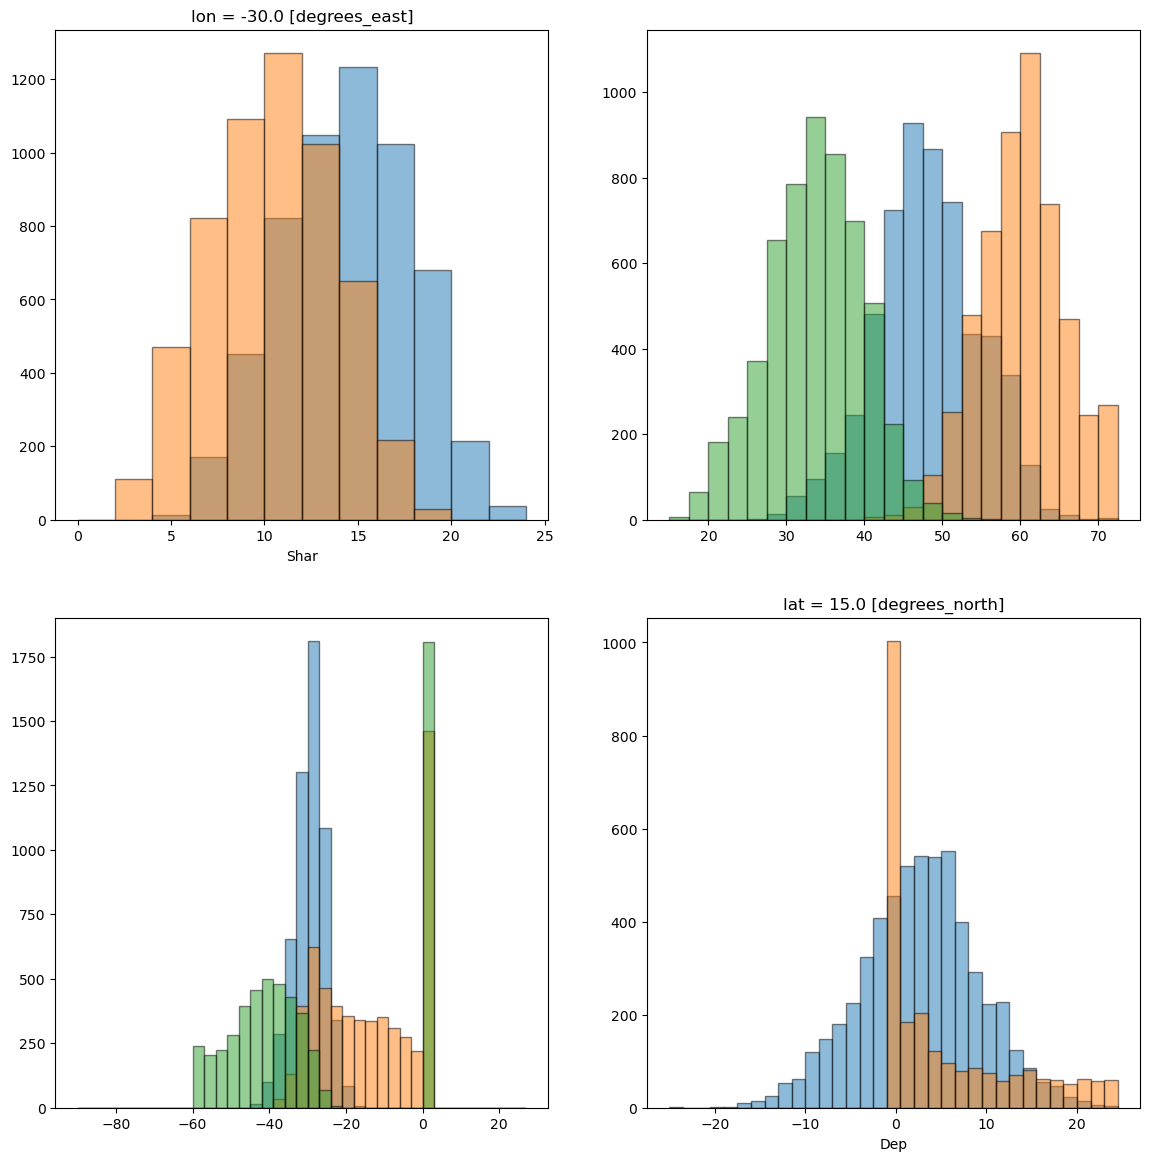

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
fig, axes[0, 0], hist = histogram(Int, "DJF", WINDBINS, fig, axes[0, 0], alpha=0.5)
fig, axes[0, 0], hist = histogram(Shar, "DJF", WINDBINS, fig, axes[0, 0], alpha=0.5)
fig, axes[0, 1], hist = histogram(Lat, "DJF", LATBINS, fig, axes[0, 1], alpha=0.5)
fig, axes[0, 1], hist = histogram(Latn, "DJF", LATBINS, fig, axes[0, 1], alpha=0.5)
fig, axes[0, 1], hist = histogram(Lats, "DJF", LATBINS, fig, axes[0, 1], alpha=0.5)
fig, axes[1, 0], hist = histogram(Lon, "DJF", LONBINS, fig, axes[1, 0], alpha=0.5)
fig, axes[1, 0], hist = histogram(Lone, "DJF", LONBINS, fig, axes[1, 0], alpha=0.5)
fig, axes[1, 0], hist = histogram(Lonw, "DJF", LONBINS, fig, axes[1, 0], alpha=0.5)
fig, axes[1, 1], hist = histogram(Tilt, "DJF", DEPBINS, fig, axes[1, 1], alpha=0.5)
fig, axes[1, 1], hist = histogram(Dep, "DJF", DEPBINS, fig, axes[1, 1], alpha=0.5)

### Create EDG filtered datasets

In [ ]:
### EDG
ds_EDG = xr.open_dataset(f"{datadir}/EDG.nc").isel(level=0)

In [ ]:
for varname in ["u", "v"]:
    da_fft_bgrnd = xrft.fft(ds_EDG[f"{varname}wnd"], dim="time")
    da_fft_trans = da_fft_bgrnd.copy()
    freq = np.abs(da_fft.freq_time)
    da_fft_bgrnd[freq > 1 / 10 / 24 / 3600] = 0
    da_fft_trans[np.logical_or(freq > 1 / 2 / 24 / 3600, freq < 1 / 6 / 24 / 3600)] = 0
    ds_EDG[f"{varname}bgrnd"] = xrft.ifft(da_fft_bgrnd, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=ds_EDG.time).rename(f"{varname}bgrnd")
    ds_EDG[f"{varname}trans"] = xrft.ifft(da_fft_trans, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=ds_EDG.time).rename(f"{varname}trans")

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:5

In [ ]:
ds_EDG.to_netcdf(f"{datadir}/EDG3.nc")

### EDG Computations

In [ ]:
ds_EDG = xr.open_dataset(f"{datadir}/EDG3.nc")

In [ ]:
ds_EDG["E1"] = (ds_EDG["vtrans"] ** 2 - ds_EDG["utrans"] ** 2) / 2
ds_EDG["E2"] = - ds_EDG["utrans"] * ds_EDG["vtrans"]
### D vector in spherical coordinates, see Obsidian page for this
ds_EDG["D1"] = ds_EDG["ubgrnd"].differentiate("lon") / RADIUS \
               - 1 / degsin(ds_EDG["lat"]) / RADIUS * ds_EDG["vbgrnd"].differentiate("lat") \
               - ds_EDG["ubgrnd"] * degcos(ds_EDG["lat"]) / degsin(ds_EDG["lat"]) / RADIUS
ds_EDG["D2"] = 0.5 * (degsin(ds_EDG["lat"]) / RADIUS * (ds_EDG["vbgrnd"] / degsin(ds_EDG["lat"])).differentiate("lon") \
                    + 1 / degsin(ds_EDG["lat"]) / RADIUS * ds_EDG["ubgrnd"].differentiate("lat"))
### Generation rate
ds_EDG["G"] = ds_EDG["E1"] * ds_EDG["D1"] + ds_EDG["E2"] * ds_EDG["D2"]
### while we're at it, let's compute the vorticity
ds_EDG["omega"] = 1 / RADIUS / degcos(ds_EDG["lat"]) * (ds_EDG["vwnd"].differentiate("lon") - (ds_EDG["uwnd"] * degcos(ds_EDG["lat"])).differentiate("lat"))

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/numpy/lib/function_base.py:1236: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/numpy/lib/function_base.py:1257: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/numpy/lib/function_base.py:1264: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


In [ ]:
ds_EDG.to_netcdf(f"{datadir}/EDG4.nc")

# Zoo statistics :

In [7]:
# datadir = "/scratch2/hugo/processed" # cal
datadir = "/scratch/snx3000/hbanderi/data/persistent" # daint

In [9]:
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooNCEP.nc")

### Autocorrelation:

In [10]:
howmany = 50
f1 = IntProgress(value=0, max=len(Zoo.data_vars))
f2 = IntProgress(value=0, max=howmany)
display(f1, f2)
autocorrs = {}

for i, varname in enumerate(Zoo):
    f2.value = 0
    autocorrs[varname] = ("lag", np.empty(howmany))
    for j in range(howmany):
        autocorrs[varname][1][j] = xr.corr(Zoo[varname], Zoo[varname].shift(time=j)).values
        f2.value = j + 1
    f1.value = i + 1
autocorrsda = xr.Dataset(autocorrs, coords={"lag": np.arange(howmany)})
autocorrsda.to_netcdf(f"{datadir}/Zoo_autocorrs.nc")

IntProgress(value=0, max=10)

IntProgress(value=0, max=50)

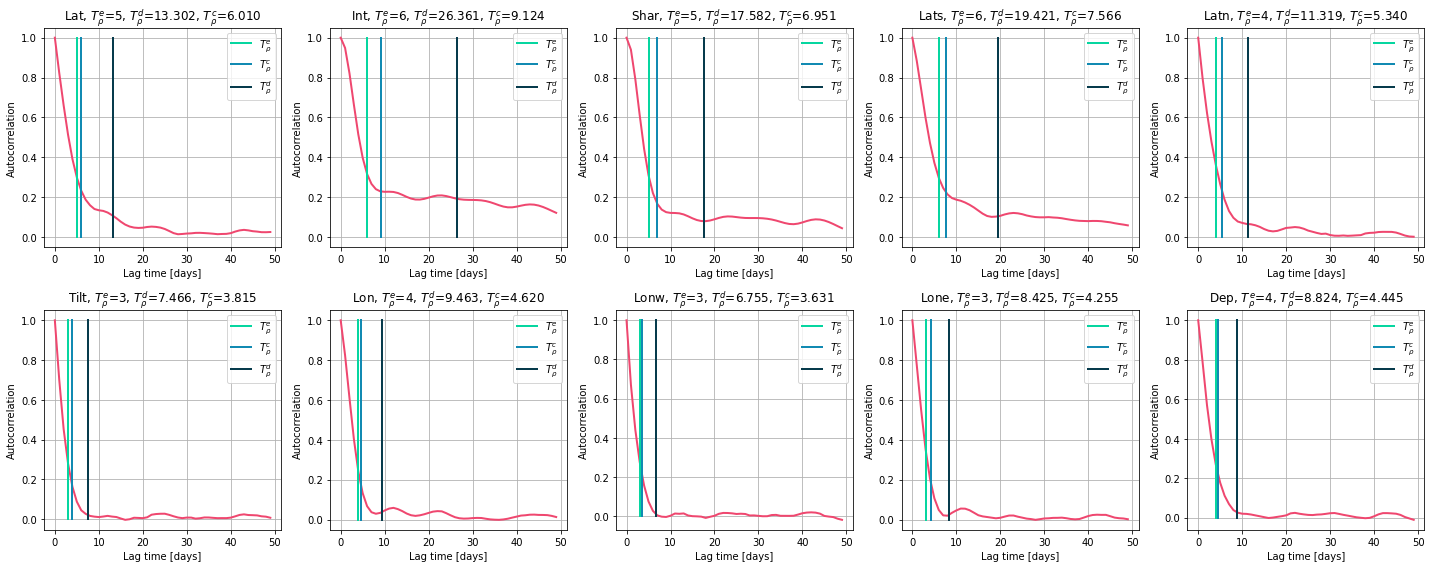

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), tight_layout=True)
axes = axes.flatten()
autocorrs = xr.open_dataset(f"{datadir}/Zoo_autocorrs.nc")
howmany = len(autocorrs.coords["lag"])
telatex = r"$T^e_{\rho}$"
tdlatex = r"$T^d_{\rho}$"
tclatex = r"$T^c_{\rho}$"
lw = 2
for i, varname in enumerate(Zoo.data_vars.keys()):
    te = np.argmax(autocorrs[varname].values <= 1 / np.exp(1))
    td = 1 + 2 * np.sum(autocorrs[varname])
    tc = 1 + np.sum(autocorrs[varname] * (1 - np.arange(1, howmany + 1) / (howmany + 1)))
    axes[i].plot(np.arange(howmany), autocorrs[varname], color=COLORS[0], lw=lw)
    axes[i].plot([te, te], [0, 1], label=telatex, color=COLORS[2], lw=lw)
    axes[i].plot([tc, tc], [0, 1], label=tclatex, color=COLORS[3], lw=lw)
    axes[i].plot([td, td], [0, 1], label=tdlatex, color=COLORS[4], lw=lw)
    axes[i].grid()
    axes[i].legend()
    axes[i].set_title(f"{varname}, {telatex}={te}, {tdlatex}={td:.3f}, {tclatex}={tc:.3f}")
    axes[i].set_ylabel("Autocorrelation")
    axes[i].set_xlabel("Lag time [days]")

### Hurst exponent

Lat [741.03033, 522.1586, 373.42523, 151.19107, 100.84141, 81.46415, 50.580227, 33.747196, 24.009817, 9.939909, 11.787007]
Int [833.3956830667049, 445.7645337096017, 335.5967483887392, 278.4237640081398, 131.04944957836256, 153.2783430925737, 111.25576667492246, 64.13834576828332, 34.59389552514709, 19.468947754689502, 8.669690197340541]
Shar [792.3684493737026, 403.6626765546228, 358.0710173591936, 252.20641373500038, 142.19878640851857, 134.5378184021952, 88.00676382791812, 52.604276836415586, 34.18475469130369, 20.140717667588213, 9.897151148250924]
Lats [559.27625, 421.44092, 361.9442, 227.88586, 133.0864, 108.054474, 65.210106, 39.682304, 27.991688, 16.585966, 11.551631]
Latn [936.3889, 534.0875, 310.10934, 215.97662, 110.31767, 77.38451, 74.743935, 46.12568, 25.825207, 16.864872, 7.4480915]
Tilt [687.4035670317836, 253.57520478176448, 200.05048633224496, 165.99023488730336, 139.89953959494773, 64.36390802094542, 21.898673670741285, 22.55250074280735, 20.892801570625544, 13.758756

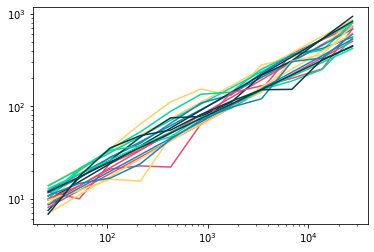

In [36]:
fig, ax = plt.subplots()
subdivs = [2**n for n in range(11)]
lengths = [len(Zoo.time) // n for n in subdivs]
all_lengths = np.repeat(lengths, subdivs)
N_chunks = np.sum(subdivs)
Hurst = {}
for i, varname in enumerate(Zoo.data_vars):
    adjusted_ranges = []
    for n_chunks, n in zip(subdivs, lengths):
        start = 0
        aranges = []
        for k in range(n_chunks):
            end = start + n
            series = Zoo[varname].isel(time=np.arange(start, end)).values
            mean = np.mean(series)
            std = np.std(series)
            series -= mean
            series = np.cumsum(series)
            raw_range = series.max() - series.min()
            aranges.append(raw_range / std)
        adjusted_ranges.append(np.mean(aranges))
    print(varname)
    ax.loglog(lengths, adjusted_ranges, color=COLORS[i%5])
    coeffs = np.polyfit(np.log(lengths), np.log(adjusted_ranges), deg=1)
    Hurst[varname] = [coeffs[0], np.exp(coeffs[1])]
    ax.loglog(lengths, np.exp(coeffs[1]) * lengths ** coeffs[0], color=COLORS[i%5])
with open(f"{datadir}/Hurst.pkl", "wb") as handle:
    pkl.dump(Hurst, handle)

### EDG statistics

In [4]:
ds_EDG = xr.open_dataset(f"/scratch2/hugo/NCEP/data/EDG4.nc", drop_variables=["uwnd", "vwnd", "utrans", "vtrans", "ubgrnd", "vbgrnd"])
ds_EDG["omega"][[0, -1], :, :] = 0

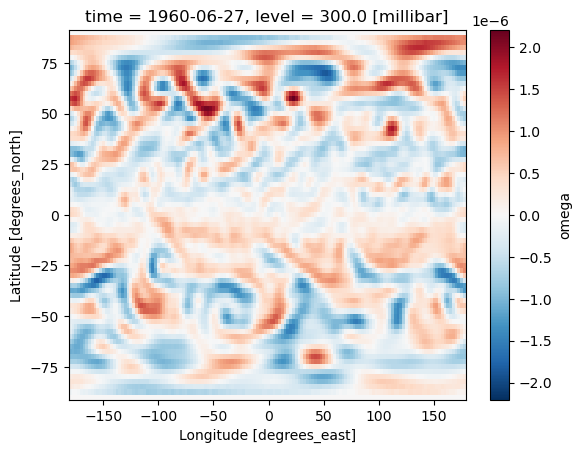

In [5]:
fig, ax = plt.subplots()
ds_EDG["omega"].isel(time=4561).plot(ax=ax)

### Create_plot

In [ ]:
def create_plot(to_plot, titles, levels, twolevel=False, startindex=-1):
    # Figure
    transform = ccrs.PlateCarree()
    projection = transform
    if twolevel:
        fig, axes = plt.subplots(
            2,
            int(len(to_plot) / 2),
            subplot_kw={"projection": projection}, constrained_layout=True #, figsize=(6 * len(to_plot) // 2, 13)
        )
    else:
        fig, axes = plt.subplots(
            1, len(to_plot), subplot_kw={"projection": projection}, constrained_layout=True, figsize=(3.5 * len(to_plot), 6)
        )
    axes = np.atleast_1d(axes)
    axes = axes.flatten()

    # Add coastline and boarders
    coastline = feat.NaturalEarthFeature(
        "physical", "coastline", "10m", edgecolor="black", facecolor="none"
    )
    borders = feat.NaturalEarthFeature(
        "cultural",
        "admin_0_boundary_lines_land",
        "10m",
        edgecolor="grey",
        facecolor="none",
    )
    plt_rej = []
    cbar = [None] * len(to_plot)
    for j in range(len(to_plot)):
        ax = axes[j]
        plt_rej.append(
            ax.contourf(
                to_plot[j]["lon"].values[:, None] * np.ones(len(to_plot[j]["lat"])),
                to_plot[j]["lat"].values[None, :] * np.ones(len(to_plot[j]["lon"]))[:, None],
                to_plot[j].isel(time=startindex).transpose(),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
        )

        ax.add_feature(coastline)
        ax.add_feature(borders)
        ax.set_xmargin(0)
        ax.set_ymargin(0)
        ax.set_title(f"Day {startindex}, {titles[j]}, g.a : {np.mean(to_plot[j][startindex]):.2f}")

        cbar[j] = fig.colorbar(plt_rej[j], ax=ax,fraction=0.046, pad=0.04)

    def animate_all(i):
        global plt_rej
        for j in range(len(to_plot)):
            ax = axes[j]
            for c in plt_rej[j].collections:
                c.remove()
            plt_rej[j] = ax.contourf(
                to_plot[j]["lon"].values[:, None] * np.ones(len(to_plot[j]["lat"])),
                to_plot[j]["lat"].values[None, :] * np.ones(len(to_plot[j]["lon"]))[:, None],
                to_plot[j].isel(time=i).transpose(),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
            ax.set_title(f"Day {i + 1}, {titles[j]}, g.a : {np.mean(to_plot[j][i]):.2f}")
            cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[len(axes) + j])
        return plt_rej

    return fig, axes, plt_rej, animate_all

### Fetch

In [ ]:
# create yearly files containing u(700-75-925), compliant with Barripedro et. al (2022); Woollings (2010)

# f1 = IntProgress(min=0, max=len(YEARSPL) * 12)
# display(f1)
for year in YEARSPL:
    for month in range(1, 13):
        fn = filenamegeneric("Woollings", year, month)
        if os.path.isfile(fn):
            # f1.value += 1
            continue
        to_merge = []
        for d in DATERANGEPL[np.logical_and(DATERANGEPL.year == year, DATERANGEPL.month == month)]:    
            to_merge.extend(fncp(d))
        xr.open_mfdataset(
            to_merge, 
            drop_variables=[v for v in longname if v != "u"], 
            engine="scipy",
        ).sel(
            level=[700.0, 750.0, 800.0, 850.0, 900.0]
        ).to_netcdf(fn)
        # f1.value += 1

In [ ]:
longname = {
    "u": "U-component of wind",
    "v": "V-component of wind",
    "w": "W-component of wind",
    "z": "Geopotential",
    "t": "Temperature",
    "vo": "Relative vorticity",
    "q": "Specific humidity",
    "r": "relative humidity"
    
}
variablemap = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for var in ["u", "v", "vo"] 
    for lev in range(700, 901, 50)
}
var = "z"
vm2 = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for lev in [300, 500]
}

variablemap.update(vm2)
variablemap["t850"] = ["t", "PL", 850, f"{longname['t']} at 850 hPa"]

### PV calculations

In [ ]:
ds = xr.open_mfdataset(fn(DATERANGEML[0], which="ML")[:1], combine="nested", concat_dim="time")
ds["P"] = (ds["hybm"] * ds["PS"] + ds["hyam"]).isel(lev_2=0).drop("lev_2").rename({"nhym": "lev"})
ds["P"].attrs["units"] = "Pa"
ds["T"].attrs["units"] = "celsius"
ds = ds.isel(lat=range(1, len(ds.lat) -1)).metpy.quantify()
ds["THETA"] = mcalc.potential_temperature(ds["P"], ds["T"])
ds["PV"] = mcalc.potential_vorticity_baroclinic(ds["THETA"], ds["P"], ds["U"], ds["V"], x_dim=3, y_dim=2, vertical_dim=1)

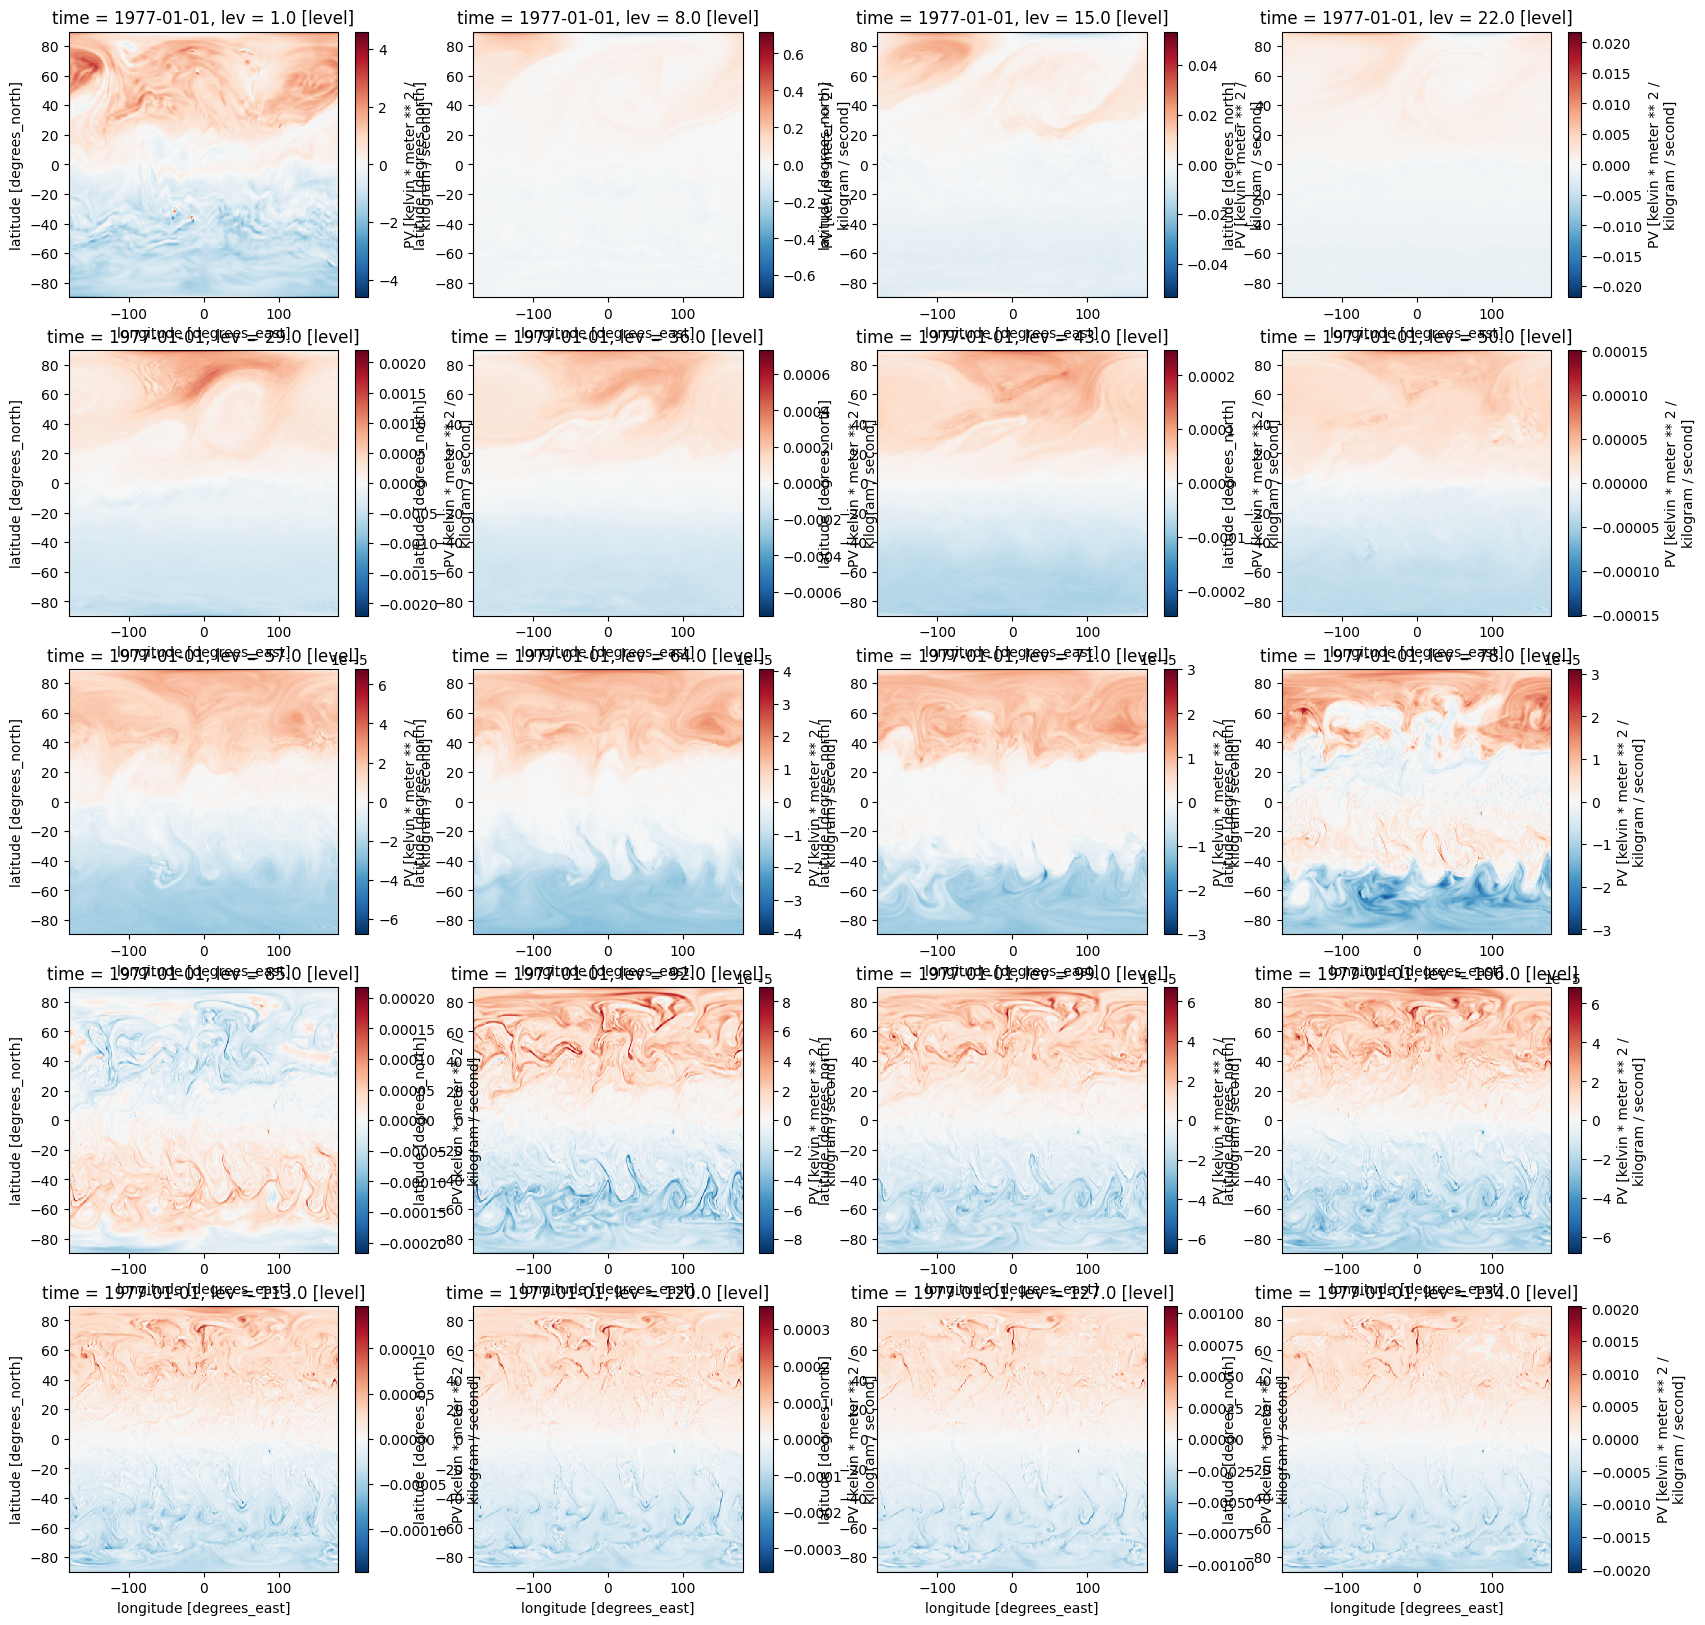

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=[20, 20])
axes = axes.flatten()
for l, k in enumerate(range(0, 137, int(137/20) + 1)):
    ds["PV"].isel(lev=k, time=0).plot(ax=axes[l])

In [ ]:
dims = ["time", "lat", "lon"]
ds["U_2PVU"] = xr.DataArray(np.empty([len(ds["T"].coords[dim]) for dim in dims]), dims=dims, coords={dim: ds["T"].coords[dim] for dim in dims})
ds["V_2PVU"] = ds["U_2PVU"].copy()
for ti, t in enumerate(ds.time):
    this_ds = ds.isel(time=ti)
    for w in ["U", "V"]:
        ds[f"{w}_2PVU"][ti, :, :] = minterpolate.interpolate_to_isosurface(this_ds["PV"].values, this_ds[w].values, 2e-6)

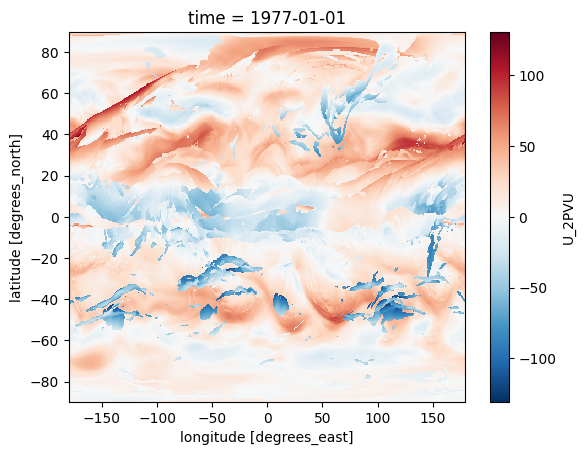

In [ ]:
ds["U_2PVU"].plot()

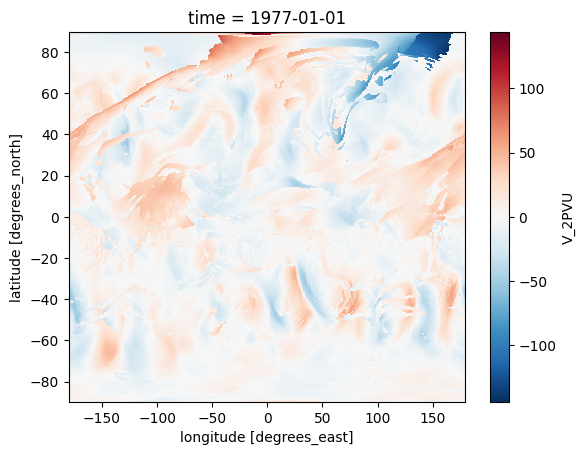

In [ ]:
ds["V_2PVU"].plot()